# Figment of Unforgettable Memories for Reinforcement Learning

##Free Energy Principle

**Leveraging Hopfield Networks and Holographic Reduced Representation**

In [1]:
# Install NENGO and related packages
!pip install nengo nengo-spa nengo-gui --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.3/542.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.1/852.1 kB 40.6 MB/s eta 0:00:00


In [2]:
from google.colab import files

import nengo
import nengo_spa as spa
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Dict, List, Tuple, Optional

# output Nengo versions
print(f'Nengo version: {nengo.__version__}')
print(f'Nengo-SPA version: {spa.__version__}')

Nengo version: 4.1.0
Nengo-SPA version: 2.0.0


In [3]:
# def build_free_energy_network(input_func, n_neurons=100, learning_rate=1e-4):
def build_free_energy_network(input_func, n_neurons, learning_rate):
    """
    Build a minimal Free Energy network.

    The network learns to predict sensory input, minimizing surprise (prediction error) over time.
    """

    model = nengo.Network(seed=42)

    with model:

        # SENSORY INPUT NODE: the actual sensory observation 'o'
        # external input source calls input_func(t) each timestep to provide sensory observation
        sensory_input = nengo.Node(output=input_func)

        # neural population that encodes the sensory input as distributed spiking activity
        sensory = nengo.Ensemble(
            n_neurons=n_neurons,
            dimensions=1,
            label='sensory'
        )
        # feed external sensory_input into sensory population, so neurons now encode the observation
        nengo.Connection(sensory_input, sensory)


        # PREDICTION
        # neural population representing the internal model's prediction g(s)
        prediction = nengo.Ensemble(
            n_neurons=n_neurons,
            dimensions=1,
            label='prediction'
        )


        # PREDICTION ERROR: the 'surprise'
        # neural population that computes prediction error: error = sensory - prediction
        error = nengo.Ensemble(
            n_neurons=n_neurons,
            dimensions=1,
            label='error'
        )

        # Error = Sensory + (-Prediction)
        # positive input to error of sensory signal
        nengo.Connection(sensory, error, synapse=0.01)
        # negative input to error of prediction
        nengo.Connection(prediction, error, transform=-1, synapse=0.01)

        # LEARNING (Free Energy Minimization)
        # PES learning adjusts weights to reduce error, using gradient descent
        learn_conn = nengo.Connection(
            sensory, prediction, # information from sensory to prediction
            function=lambda x: 0, # output prediction of 0 to start
            learning_rule_type=nengo.PES(learning_rate=learning_rate), # Prescribed Error Sensitivity, small learning rate
            synapse=0.01 # 10 millisecond lowpass filter to smooth learning
        )

        # connect the error signal to the PES learning
        nengo.Connection(error, learn_conn.learning_rule, transform=-1)

        # PROBES
        # input function
        model.p_input = nengo.Probe(sensory_input)
        # neural encording of input
        model.p_sensory = nengo.Probe(sensory, synapse=0.01)
        # learned predictions
        model.p_prediction = nengo.Probe(prediction, synapse=0.01)
        # prediction error
        model.p_error = nengo.Probe(error, synapse=0.01)

    return model

print('Free Energy Network defined.')

Free Energy Network defined.


In [4]:
# set a constant sensory input
def constant_signal(t):
    return 0.5

# build the above defined network based on defined arguments
model = build_free_energy_network(
    input_func=constant_signal,
    n_neurons=100,
    learning_rate=0.0001 # default PES learning
)

# run NENGO simulation
with nengo.Simulator(model) as sim:
    sim.run(4.0)  # 4 seconds

print('Simulation complete.')

ERROR:nengo.cache:Decoder cache index corrupted. Reinitializing cache.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/nengo/cache.py", line 467, in __enter__
    self._load_index_file()
  File "/usr/local/lib/python3.12/dist-packages/nengo/cache.py", line 389, in _load_index_file
    with self.index_path.open("rb") as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/pathlib.py", line 1013, in open
    return io.open(self, mode, buffering, encoding, errors, newline)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/nengo/decoders/index'


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Simulation complete.


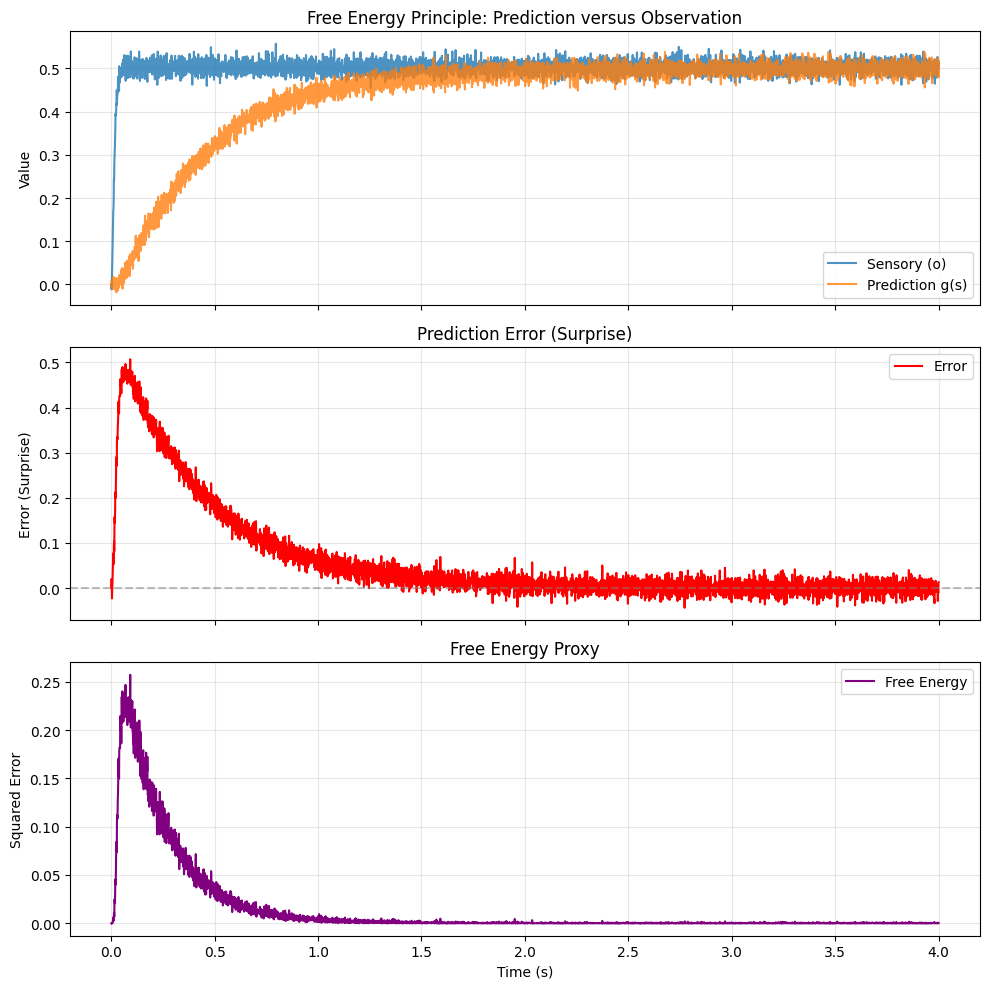

In [5]:
fig1, axes1 = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Plot 1: Sensory vs Prediction time range
axes1[0].plot(sim.trange(), sim.data[model.p_sensory], label='Sensory (o)', alpha=0.8)
axes1[0].plot(sim.trange(), sim.data[model.p_prediction], label='Prediction g(s)', alpha=0.8)
axes1[0].set_ylabel('Value')
axes1[0].set_title('Free Energy Principle: Prediction versus Observation')
axes1[0].legend()
axes1[0].grid(True, alpha=0.3)

# Plot 2: Prediction Error (Surprise) time range
axes1[1].plot(sim.trange(), sim.data[model.p_error], color='red', label='Error')
axes1[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes1[1].set_ylabel('Error (Surprise)')
axes1[1].set_title('Prediction Error (Surprise)')
axes1[1].legend()
axes1[1].grid(True, alpha=0.3)

# based on Gaussianian distribution, a proxy of Free Energy
# smoothing positive and negative 'surprises'

# Plot 3: Squared Error (Free Energy Proxy) time range
squared_error = sim.data[model.p_error]**2
axes1[2].plot(sim.trange(), squared_error, color='purple', label='Free Energy')
axes1[2].set_ylabel('Squared Error')
axes1[2].set_xlabel('Time (s)')
axes1[2].set_title('Free Energy Proxy')
axes1[2].legend()
axes1[2].grid(True, alpha=0.3)

fig1.tight_layout()
plt.show()

In [6]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# # Plot 1: Sensory vs Prediction time range
# axes[0].plot(sim.trange(), sim.data[model.p_sensory], label='Sensory (o)', alpha=0.8)
# axes[0].plot(sim.trange(), sim.data[model.p_prediction], label='Prediction g(s)', alpha=0.8)
# axes[0].set_ylabel('Value')
# axes[0].set_title('Free Energy Principle: Prediction Learns to Match Observation')
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)

# # Plot 2: Prediction Error (Surprise) time range
# axes[1].plot(sim.trange(), sim.data[model.p_error], color='red', label='Error')
# axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
# axes[1].set_ylabel('Error (Surprise)')
# axes[1].set_title('Prediction Error (Surprise) - Should Approach Zero')
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)

# based on Gaussianian distribution, a proxy of Free Energy
# smoothing positive and negative 'surprises'

# # Plot 3: Squared Error (Free Energy Proxy) time range
# squared_error = sim.data[model.p_error]**2
# axes[2].plot(sim.trange(), squared_error, color='purple', label='Free Energy')
# axes[2].set_ylabel('Squared Error')
# axes[2].set_xlabel('Time (s)')
# axes[2].set_title('Free Energy Proxy')
# axes[2].legend()
# axes[2].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

In [7]:
# save each subplot as individual .png file
for i, ax in enumerate(axes1):
    extent = ax.get_window_extent().transformed(fig1.dpi_scale_trans.inverted())
    fname = f"fep_3x1_subplot_{i+1}.png"
    fig1.savefig(fname, bbox_inches=extent, dpi=150)
    files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# EVALUATION

# calculate the error reduction, from the error probe, converted to 1 dimension
error = sim.data[model.p_error].flatten()
t = sim.trange()

# early vs later error
early_error = np.mean(np.abs(error[:500]))   # first 500 milliseconds
late_error = np.mean(np.abs(error[-500:]))   # last 500 milliseconds

print(f'Early surprise (mean absolute error): {early_error:.4f}')
print(f'Late surprise (mean absolute error):  {late_error:.4f}')
print(f'Surprise reduction: {(1 - late_error/early_error)*100:.1f}%')

# final prediction accuracy, from prediction probe, last 500 milliseconds
final_prediction = np.mean(sim.data[model.p_prediction][-500:])
target = 0.5
print(f'\nTarget value: {target}')
print(f'Final prediction: {final_prediction:.4f}')

Early surprise (mean absolute error): 0.3113
Late surprise (mean absolute error):  0.0116
Surprise reduction: 96.3%

Target value: 0.5
Final prediction: 0.4990


In [9]:
# define a sine wave input
def sine_wave(t):
    return 0.5 * np.sin(2 * np.pi * t)

# build the above defined network based on updated arguments
model_sine = build_free_energy_network(
    input_func=sine_wave,
    n_neurons=200,
    learning_rate=0.00005 # slower learning
)

# run longer for the sine wave signal
with nengo.Simulator(model_sine) as sim:
    sim.run(10.0)  # 10 seconds

print('Sine wave simulation complete.')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Sine wave simulation complete.


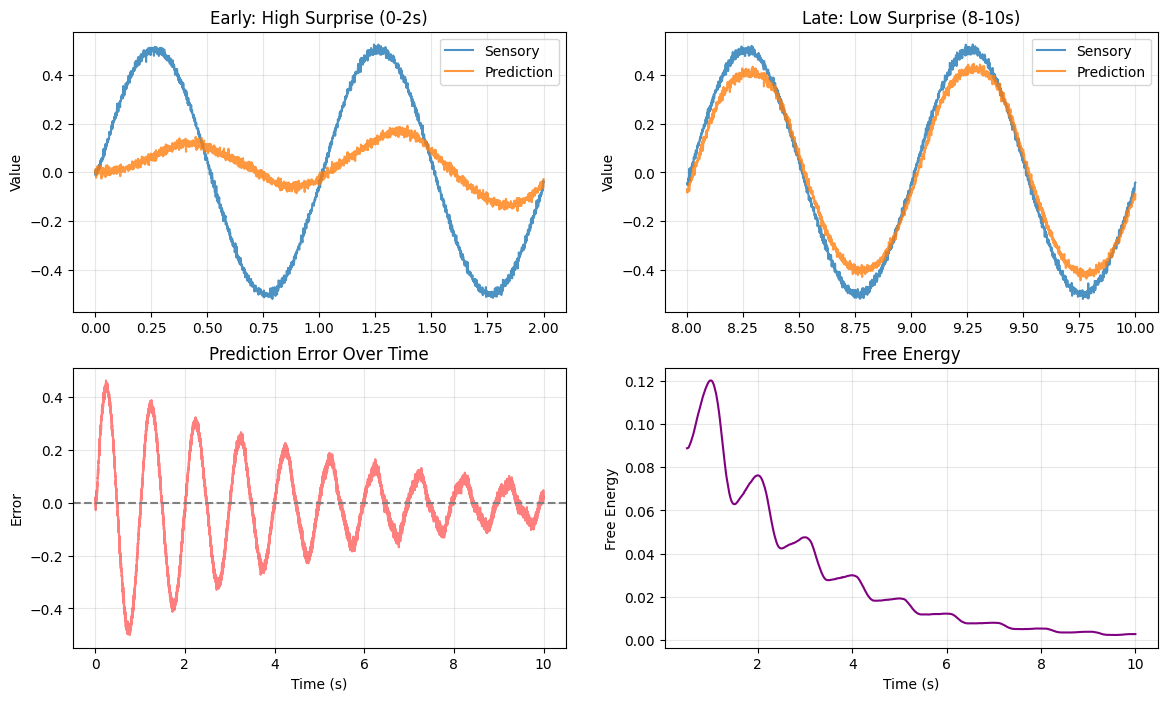

In [10]:
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 8))

t = sim.trange()
sensory = sim.data[model_sine.p_sensory].flatten()
prediction = sim.data[model_sine.p_prediction].flatten()
error = sim.data[model_sine.p_error].flatten()

# Plot 1
axes2[0, 0].plot(t[:2000], sensory[:2000], label='Sensory', alpha=0.8)
axes2[0, 0].plot(t[:2000], prediction[:2000], label='Prediction', alpha=0.8)
axes2[0, 0].set_title('Early: High Surprise (0-2s)')
axes2[0, 0].set_ylabel('Value')
axes2[0, 0].legend()
axes2[0, 0].grid(True, alpha=0.3)

# Plot 2
axes2[0, 1].plot(t[-2000:], sensory[-2000:], label='Sensory', alpha=0.8)
axes2[0, 1].plot(t[-2000:], prediction[-2000:], label='Prediction', alpha=0.8)
axes2[0, 1].set_title('Late: Low Surprise (8-10s)')
axes2[0, 1].set_ylabel('Value')
axes2[0, 1].legend()
axes2[0, 1].grid(True, alpha=0.3)

# Plot 3
axes2[1, 0].plot(t, error, color='red', alpha=0.5)
axes2[1, 0].axhline(y=0, color='gray', linestyle='--')
axes2[1, 0].set_title('Prediction Error Over Time')
axes2[1, 0].set_xlabel('Time (s)')
axes2[1, 0].set_ylabel('Error')
axes2[1, 0].grid(True, alpha=0.3)

# Plot 4: moving average of Free Energy
window = 500 # samples
# absolute error convolved to generate moving average
smoothed_fe = np.convolve(error**2, np.ones(window)/window, mode='valid')
axes2[1, 1].plot(t[window-1:], smoothed_fe, color='purple')
axes2[1, 1].set_title('Free Energy')
axes2[1, 1].set_xlabel('Time (s)')
axes2[1, 1].set_ylabel('Free Energy')
axes2[1, 1].grid(True, alpha=0.3)

In [11]:
# save each subplot as individual .png file
axes2_flat = axes2.ravel()
for i, ax in enumerate(axes2_flat):
    extent = ax.get_window_extent().transformed(fig2.dpi_scale_trans.inverted())
    fname = f"fep_2x2_subplot_{i+1}.png"
    fig2.savefig(fname, bbox_inches=extent, dpi=150)
    files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# EVALUATION

# collect the input sensory, prediction and error data, converted to 1 dimension
sensory = sim.data[model_sine.p_sensory].flatten()
prediction = sim.data[model_sine.p_prediction].flatten()
error = sim.data[model_sine.p_error].flatten()

# 1. compare early vs late error
early_error = np.mean(np.abs(error[:500])) # first 500 milliseconds
late_error = np.mean(np.abs(error[-500:])) # last 500 milliseconds

print(f'Early surprise mean absolute error: {early_error:.4f}')
print(f'Late surprise mean absolute error:  {late_error:.4f}')
print(f'Surprise reduction: {(1 - late_error/early_error)*100:.1f}%')

# 2. the Pearson correlation between prediction and sensory, late evaluation
late_correlation = np.corrcoef(sensory[-500:], prediction[-500:])[0, 1]
# output row 0, column 1 detailing correlation between sensory and prediction
print(f'\nLate correlation (prediction vs sensory): {late_correlation:.4f}')

# 3. R-squared score
sum_square_resid = np.sum((sensory[-500:] - prediction[-500:])**2)
sum_square_total = np.sum((sensory[-500:] - np.mean(sensory[-500:]))**2)
r_squared = 1 - (sum_square_resid / sum_square_total)
print(f'Late R-squared score: {r_squared:.4f}')

Early surprise mean absolute error: 0.2587
Late surprise mean absolute error:  0.0466
Surprise reduction: 82.0%

Late correlation (prediction vs sensory): 0.9758
Late R-squared score: 0.8631


# NEW

In [13]:
# === HOPFIELD: Store FEP prediction snapshots as attractors ===

# sample 4 time snapshots from FEP simulation (binarized predictions)
times = [500, 1500, 2500, 3500]  # timestep indices

# convert the continuous FEP sine wave predictions into classic binary Hopfield patters
patterns = np.array([np.sign(sim.data[model_sine.p_prediction][t:t+64].flatten()) for t in times])

# Hebbian learning: W = sum of outer products, using classic Hopfield
n = patterns.shape[1]
# generate and fill the matrix
W = sum(np.outer(p, p) for p in patterns) / n
np.fill_diagonal(W, 0)

# to test memory recall, simulated with 20% 'noise' converting value to -1
noisy = patterns[0].copy()
noisy[np.random.choice(n, n//5, replace=False)] *= -1  # 20% noise

# recall matrix multiplication between original values and noisey values
recalled = np.sign(W @ noisy)

print("Hopfield + FEP Integration")
print(f"Stored {len(patterns)} FEP snapshots as stable state attractors")
print(f"Recall accuracy: {np.mean(recalled == patterns[0]):.0%}")

Hopfield + FEP Integration
Stored 4 FEP snapshots as stable state attractors
Recall accuracy: 100%


In [14]:
# === HRR: Encode FEP states with structure ===

D = 128  # vector dimensions

# create random role vectors
np.random.seed(42)
TIME = np.random.randn(D) # vector of 128 values from standard normal
TIME /= np.linalg.norm(TIME) # Euclidean (L2) norm

VALUE = np.random.randn(D) # vector of 128 values from standard normal
VALUE /= np.linalg.norm(VALUE) # Euclidean (L2) norm

# circular convolution (bind) via textbook signal processing using FFT / Fourier transform
bind = lambda a, b: np.fft.ifft(np.fft.fft(a) * np.fft.fft(b)).real

# extract the early vs late mean FEP predictions
early_pred = np.mean(sim.data[model_sine.p_prediction][:500])
late_pred = np.mean(sim.data[model_sine.p_prediction][-500:])

# convert mean scalar values to vectors based on 128 dimensions
np.random.seed(1); early_vec = np.random.randn(D) * early_pred
np.random.seed(2); late_vec = np.random.randn(D) * late_pred

# circular convolution using FTT to bind and bundle both into memory
memory = bind(TIME, early_vec) + bind(VALUE, late_vec)
memory /= np.linalg.norm(memory) # Euclidean (L2) norm

print("HRR + FEP Integration")
print(f"Encoded FEP predictions: early={early_pred:.3f}, late={late_pred:.3f}")
print(f"Memory vector norm: {np.linalg.norm(memory):.2f}")

HRR + FEP Integration
Encoded FEP predictions: early=0.061, late=-0.273
Memory vector norm: 1.00


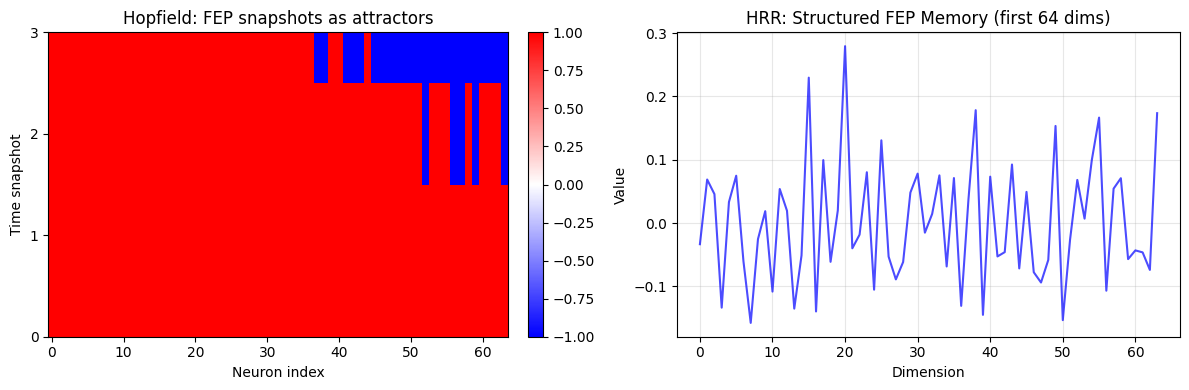

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Hopfield patterns from FEP

im = axes[0].imshow(
    patterns,
    aspect='auto',
    cmap='bwr',
    vmin=-1, vmax=1
)
axes[0].set_ylim(0, 3)        # bottom=0, top=3
axes[0].set_yticks([0, 1, 2, 3])
axes[0].set_xlabel('Neuron index')
axes[0].set_ylabel('Time snapshot')
axes[0].set_title('Hopfield: FEP snapshots as attractors')
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

# Right: HRR memory vector
axes[1].plot(memory[:64], 'b-', alpha=0.7)
axes[1].set_xlabel('Dimension')
axes[1].set_ylabel('Value')
axes[1].set_title('HRR: Structured FEP Memory (first 64 dims)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()